# Лабораторная 3

Датасет: Информация об онлайн обучении учеников

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import featuretools as ft
import time
import math
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

df = pd.read_csv("..\\static\\csv\\students_adaptability_level_online_education.csv")
print(df.columns)

Index(['Education Level', 'Institution Type', 'Gender', 'Age', 'Device',
       'IT Student', 'Location', 'Financial Condition', 'Internet Type',
       'Network Type', 'Flexibility Level'],
      dtype='object')


Столбцы:

Education Level - уровень образования\
Institution Type - тип учреждения\
Gender - пол\
Age - возраст\
Device - устройство\
IT Student - ученик IT направления или нет\
Location - локация\
Financial Condition - финансовое состояние\
Internet Type - тип доступа к сети\
Network Type - уровень сети\
Flexibility Level - уровень приспособления

In [2]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Education Level      1205 non-null   object
 1   Institution Type     1205 non-null   object
 2   Gender               1205 non-null   object
 3   Age                  1205 non-null   int64 
 4   Device               1205 non-null   object
 5   IT Student           1205 non-null   object
 6   Location             1205 non-null   object
 7   Financial Condition  1205 non-null   object
 8   Internet Type        1205 non-null   object
 9   Network Type         1205 non-null   object
 10  Flexibility Level    1205 non-null   object
dtypes: int64(1), object(10)
memory usage: 103.7+ KB


Education Level Institution Type  Gender  Age  Device IT Student Location  \
0      University          Private    Male   23     Tab         No     Town   
1      University          Private  Female   23  Mobile         No     Town   
2         College           Public  Female   18  Mobile         No     Town   
3          School          Private  Female   11  Mobile         No     Town   
4          School          Private  Female   18  Mobile         No     Town   

  Financial Condition Internet Type Network Type Flexibility Level  
0                 Mid          Wifi           4G          Moderate  
1                 Mid   Mobile Data           4G          Moderate  
2                 Mid          Wifi           4G          Moderate  
3                 Mid   Mobile Data           4G          Moderate  
4                Poor   Mobile Data           3G               Low

Примеры бизнес-целей для датасета:
1. Улучшение доступа к онлайн-образованию для учеников с низким уровнем финансового обеспечения.
2. Повышение удовлетворенности учеников онлайн-обучением на основе их устройств, типу соединения, местоположения.

Цели технического проекта:

1. Провести анализ зависимости учеников от уровня интернет-соединения и устройств
2. Провести анализ влияния различных факторов (тип устройства, интернет-соединение, финансовое положение) на уровень приспособленности.

Проверяем на выбросы.

In [3]:
null_values = df.isnull().sum()
print("Пустые значения по столбцам:")
print(null_values)

duplicates = df.duplicated().sum()
print(f"\nКоличество дубликатов: {duplicates}")

print("\nСтатистический обзор данных:")
df.describe()

for column in df.select_dtypes(include=[np.number]).columns:
    skewness = df[column].skew()
    print(f"\nКоэффициент асимметрии для столбца '{column}': {skewness}")

Пустые значения по столбцам:
Education Level        0
Institution Type       0
Gender                 0
Age                    0
Device                 0
IT Student             0
Location               0
Financial Condition    0
Internet Type          0
Network Type           0
Flexibility Level      0
dtype: int64

Количество дубликатов: 980

Статистический обзор данных:

Коэффициент асимметрии для столбца 'Age': 0.024342017300169792


Выбросы незначительны, дубликаты есть. Удаляем дубликаты и очищаем от шумов.

In [4]:
cleaned_df = df.drop_duplicates()

Q1 = df["Age"].quantile(0.25)
Q3 = df["Age"].quantile(0.75)

IQR = Q3 - Q1

threshold = 1.5 * IQR
lower_bound = Q1 - threshold
upper_bound = Q3 + threshold

outliers = (df["Age"] < lower_bound) | (df["Age"] > upper_bound)

print("Шумы в датасете:")
print(df[outliers])

median_score = df["Age"].median()
df.loc[outliers, "Age"] = median_score

Шумы в датасете:
Empty DataFrame
Columns: [Education Level, Institution Type, Gender, Age, Device, IT Student, Location, Financial Condition, Internet Type, Network Type, Flexibility Level]
Index: []


Преобразуем строковые значение в столбце "Уровень приспособления" в числовые значения. Это понадобится для расчёта качества набора признаков.

In [5]:
map_flexibility_to_int = {'Low': 0, 'Moderate': 1, 'High': 2}

df['Flexibility Level'] = df['Flexibility Level'].map(map_flexibility_to_int).astype('int32')

Шумов в датасете нет. Разбиваем датасет на три выборки: обучающую, контрольную и тестовую.

In [6]:
X = df.drop(columns=['Flexibility Level'])
Y = df['Flexibility Level']

X_train_df, X_test_df, Y_train_df, Y_test_df = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train_df, X_val_df, Y_train_df, Y_val_df = train_test_split(X_train_df, Y_train_df, test_size=0.25, random_state=42)

print("Размер обучающей выборки:", X_train_df.shape)
print("Размер контрольной выборки:",X_val_df.shape)
print("Размер тестовой выборки:", X_test_df.shape)

Размер обучающей выборки: (723, 10)
Размер контрольной выборки: (241, 10)
Размер тестовой выборки: (241, 10)


Проверка сбалансированности данных.

Распределение классов в обучающей выборке:
Flexibility Level
1    0.531120
0    0.385892
2    0.082988
Name: proportion, dtype: float64

Распределение классов в контрольной выборке:
Flexibility Level
1    0.522822
0    0.406639
2    0.070539
Name: proportion, dtype: float64

Распределение классов в тестовой выборке:
Flexibility Level
1    0.477178
0    0.427386
2    0.095436
Name: proportion, dtype: float64


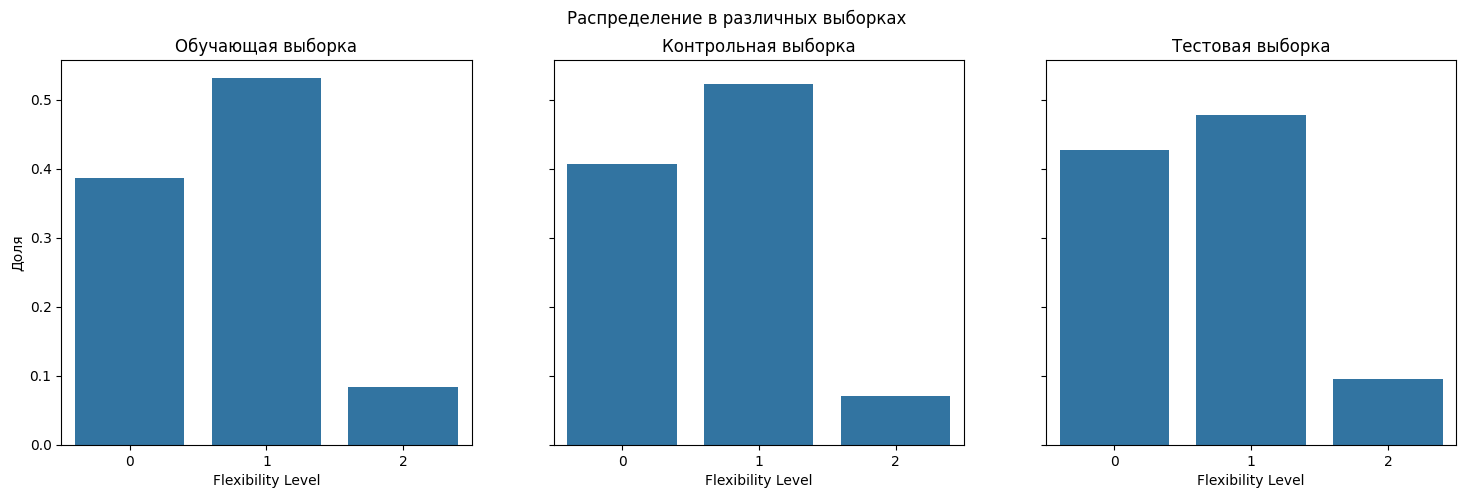

In [7]:

def analyze_balance(y_train, y_val, y_test, y_name):
    print("Распределение классов в обучающей выборке:")
    print(y_train.value_counts(normalize=True))
    
    print("\nРаспределение классов в контрольной выборке:")
    print(y_val.value_counts(normalize=True))
    
    print("\nРаспределение классов в тестовой выборке:")
    print(y_test.value_counts(normalize=True))

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    fig.suptitle('Распределение в различных выборках')

    sns.barplot(x=y_train.value_counts().index, y=y_train.value_counts(normalize=True), ax=axes[0])
    axes[0].set_title('Обучающая выборка')
    axes[0].set_xlabel(y_name)
    axes[0].set_ylabel('Доля')

    sns.barplot(x=y_val.value_counts().index, y=y_val.value_counts(normalize=True), ax=axes[1])
    axes[1].set_title('Контрольная выборка')
    axes[1].set_xlabel(y_name)

    sns.barplot(x=y_test.value_counts().index, y=y_test.value_counts(normalize=True), ax=axes[2])
    axes[2].set_title('Тестовая выборка')
    axes[2].set_xlabel(y_name)

    plt.show()

analyze_balance(Y_train_df, Y_val_df, Y_test_df, 'Flexibility Level')

Выполним оверсемплинг для балансировки.

Распределение классов в обучающей выборке:
Flexibility Level
2    0.333333
0    0.333333
1    0.333333
Name: proportion, dtype: float64

Распределение классов в контрольной выборке:
Flexibility Level
1    0.333333
0    0.333333
2    0.333333
Name: proportion, dtype: float64

Распределение классов в тестовой выборке:
Flexibility Level
1    0.477178
0    0.427386
2    0.095436
Name: proportion, dtype: float64


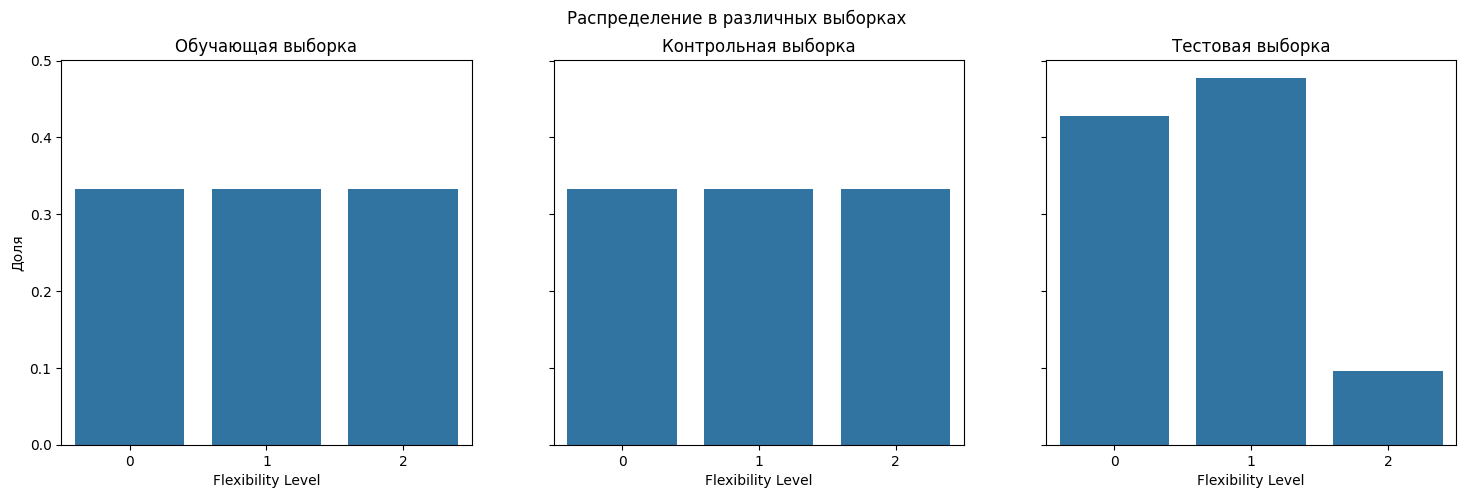

In [8]:
ros = RandomOverSampler(random_state=42)

X_train_resampled, Y_train_resampled = ros.fit_resample(X_train_df, Y_train_df)
X_val_resampled, Y_val_resampled = ros.fit_resample(X_val_df, Y_val_df)

analyze_balance(Y_train_resampled, Y_val_resampled, Y_test_df, 'Flexibility Level')

Конструирование признаков. Для начала применим унитарное кодирование категориальных признаков (one-hot encoding), переведя их в бинарные вектора.

In [9]:
cat_features = ['Education Level', 'Institution Type', 'Gender', 'Device', 'IT Student', 'Location', 'Financial Condition', 'Internet Type', 'Network Type']

train_encoded = pd.get_dummies(X_train_resampled, columns=cat_features, drop_first=True)
val_encoded = pd.get_dummies(X_val_resampled, columns=cat_features, drop_first=True)
test_encoded = pd.get_dummies(X_test_df, columns=cat_features, drop_first=True)

train_encoded.head()

Age  Education Level_School  Education Level_University  \
0   10                    True                       False   
1   18                   False                       False   
2   23                   False                        True   
3   18                    True                       False   
4   23                   False                        True   

   Institution Type_Public  Gender_Male  Device_Mobile  Device_Tab  \
0                    False         True           True       False   
1                    False        False           True       False   
2                    False         True           True       False   
3                     True         True           True       False   
4                    False        False           True       False   

   IT Student_Yes  Location_Town  Financial Condition_Poor  \
0           False           True                     False   
1           False           True                     False   
2           False           True                     False   
3           False           True                     False   
4           False          False                     False   

   Financial Condition_Rich  Internet Type_Wifi  Network Type_3G  \
0                      True                True            False   
1                     False                True            False   
2                     False                True            False   
3                      True               False            False   
4                     False                True            False   

   Network Type_4G  
0             True  
1             True  
2             True  
3             True  
4             True

Применим дискретизацию к числовым признакам.

In [10]:
num_features = ['Age']

def discretize_features(df, features, bins, labels):
    for feature in features:
        df[f'{feature}_Bin'] = pd.cut(df[feature], bins=bins, labels=labels)
        df.drop(columns=[feature], inplace=True)
    return df

age_bins = [0, 25, 55, 100]
age_labels = ["young", "middle-aged", "old"]

train_encoded = discretize_features(train_encoded, num_features, bins=age_bins, labels=age_labels)
val_encoded = discretize_features(val_encoded, num_features, bins=age_bins, labels=age_labels)
test_encoded = discretize_features(test_encoded, num_features, bins=age_bins, labels=age_labels)

train_encoded.head()

Education Level_School  Education Level_University  \
0                    True                       False   
1                   False                       False   
2                   False                        True   
3                    True                       False   
4                   False                        True   

   Institution Type_Public  Gender_Male  Device_Mobile  Device_Tab  \
0                    False         True           True       False   
1                    False        False           True       False   
2                    False         True           True       False   
3                     True         True           True       False   
4                    False        False           True       False   

   IT Student_Yes  Location_Town  Financial Condition_Poor  \
0           False           True                     False   
1           False           True                     False   
2           False           True                     False   
3           False           True                     False   
4           False          False                     False   

   Financial Condition_Rich  Internet Type_Wifi  Network Type_3G  \
0                      True                True            False   
1                     False                True            False   
2                     False                True            False   
3                      True               False            False   
4                     False                True            False   

   Network Type_4G Age_Bin  
0             True   young  
1             True   young  
2             True   young  
3             True   young  
4             True   young

Применим ручной синтез признаков. К примеру, для этого датасета, сделаем признак "соотвествие устройства для обучения". Мобильные устройства часто менее удобны для учебы по сравнению с планшетами.

In [11]:
train_encoded['Device Suitability'] = train_encoded['Device_Tab'].apply(lambda x: "High" if x == True else "Low")
val_encoded['Device Suitability'] = val_encoded['Device_Tab'].apply(lambda x: "High" if x == True else "Low")
test_encoded['Device Suitability'] = test_encoded['Device_Tab'].apply(lambda x: "High" if x == True else "Low")

train_encoded.head()

Education Level_School  Education Level_University  \
0                    True                       False   
1                   False                       False   
2                   False                        True   
3                    True                       False   
4                   False                        True   

   Institution Type_Public  Gender_Male  Device_Mobile  Device_Tab  \
0                    False         True           True       False   
1                    False        False           True       False   
2                    False         True           True       False   
3                     True         True           True       False   
4                    False        False           True       False   

   IT Student_Yes  Location_Town  Financial Condition_Poor  \
0           False           True                     False   
1           False           True                     False   
2           False           True                     False   
3           False           True                     False   
4           False          False                     False   

   Financial Condition_Rich  Internet Type_Wifi  Network Type_3G  \
0                      True                True            False   
1                     False                True            False   
2                     False                True            False   
3                      True               False            False   
4                     False                True            False   

   Network Type_4G Age_Bin Device Suitability  
0             True   young                Low  
1             True   young                Low  
2             True   young                Low  
3             True   young                Low  
4             True   young                Low

Конструирование признаков с помощью фреймворка Featuretools.

In [12]:
ft_data = train_encoded.copy()

es = ft.EntitySet(id="students")
es = es.add_dataframe(dataframe_name="students_data", dataframe=ft_data, index="id", make_index=True)

feature_matrix, feature_defs = ft.dfs(
    entityset=es, 
    target_dataframe_name="students_data",
    max_depth=1
)

feature_matrix.head()

d:\ulstu\cr3\sem1\MAI\AIM-PIbd-31-Makarov-DV\.venv\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
d:\ulstu\cr3\sem1\MAI\AIM-PIbd-31-Makarov-DV\.venv\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
d:\ulstu\cr3\sem1\MAI\AIM-PIbd-31-Makarov-DV\.venv\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(


Education Level_School  Education Level_University  \
id                                                       
0                     True                       False   
1                    False                       False   
2                    False                        True   
3                     True                       False   
4                    False                        True   

    Institution Type_Public  Gender_Male  Device_Mobile  Device_Tab  \
id                                                                    
0                     False         True           True       False   
1                     False        False           True       False   
2                     False         True           True       False   
3                      True         True           True       False   
4                     False        False           True       False   

    IT Student_Yes  Location_Town  Financial Condition_Poor  \
id                                                            
0            False           True                     False   
1            False           True                     False   
2            False           True                     False   
3            False           True                     False   
4            False          False                     False   

    Financial Condition_Rich  Internet Type_Wifi  Network Type_3G  \
id                                                                  
0                       True                True            False   
1                      False                True            False   
2                      False                True            False   
3                       True               False            False   
4                      False                True            False   

    Network Type_4G Age_Bin Device Suitability  
id                                              
0              True   young                Low  
1              True   young                Low  
2              True   young                Low  
3              True   young                Low  
4              True   young                Low

Featuretools не смог сделать новые признаки.

Оценка качества набора признаков.

In [13]:
train_encoded = pd.get_dummies(train_encoded, drop_first=True)
val_encoded = pd.get_dummies(val_encoded, drop_first=True)
test_encoded = pd.get_dummies(test_encoded, drop_first=True)

cols = train_encoded.columns

train_encoded = train_encoded.reindex(columns=cols, fill_value=0)
val_encoded = val_encoded.reindex(columns=cols, fill_value=0)
test_encoded = test_encoded.reindex(columns=cols, fill_value=0)

model = RandomForestClassifier(n_estimators=100, random_state=42)

start = time.time()
model.fit(train_encoded, Y_train_resampled)
train_time = time.time() - start

print(f'Время обучения модели: {train_time:.2f} секунд')

Время обучения модели: 0.11 секунд


In [14]:
# Получение важности признаков
importances = model.feature_importances_
feature_names = train_encoded.columns

# Сортировка признаков по важности
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

Feature Importance:
                       feature  importance
9     Financial Condition_Rich    0.184028
3                  Gender_Male    0.108992
8     Financial Condition_Poor    0.107030
2      Institution Type_Public    0.095663
10          Internet Type_Wifi    0.089925
7                Location_Town    0.078658
0       Education Level_School    0.061961
6               IT Student_Yes    0.055048
1   Education Level_University    0.049695
12             Network Type_4G    0.044837
4                Device_Mobile    0.042086
11             Network Type_3G    0.038541
13         Age_Bin_middle-aged    0.034876
15      Device Suitability_Low    0.004611
5                   Device_Tab    0.004049
14                 Age_Bin_old    0.000000


In [15]:
y_pred = model.predict(test_encoded)

# Анализ важности признаков
feature_importances = model.feature_importances_
feature_names = train_encoded.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

rmse = mean_squared_error(Y_test_df, y_pred, squared=False)
r2 = r2_score(Y_test_df, y_pred)
mae = mean_absolute_error(Y_test_df, y_pred)

print()
print(f"RMSE: {rmse}")
print(f"R²: {r2}")
print(f"MAE: {mae} \n")

# Кросс-валидация
scores = cross_val_score(model, train_encoded, Y_train_resampled, cv=5, scoring='neg_mean_squared_error')
rmse_cv = math.sqrt((-scores.mean()))
print(f"Кросс-валидация RMSE: {rmse_cv} \n")

# Проверка на переобучение
y_train_pred = model.predict(train_encoded)

rmse_train = mean_squared_error(Y_train_resampled, y_train_pred, squared=False)
r2_train = r2_score(Y_train_resampled, y_train_pred)
mae_train = mean_absolute_error(Y_train_resampled, y_train_pred)

print(f"Train RMSE: {rmse_train}")
print(f"Train R²: {r2_train}")
print(f"Train MAE: {mae_train}")
print()

d:\ulstu\cr3\sem1\MAI\AIM-PIbd-31-Makarov-DV\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



RMSE: 0.5652451456569942
R²: 0.22569473420679287
MAE: 0.2697095435684647 

Кросс-валидация RMSE: 0.5705060311373475 

Train RMSE: 0.5237418787490223
Train R²: 0.5885416666666667
Train MAE: 0.19791666666666666



d:\ulstu\cr3\sem1\MAI\AIM-PIbd-31-Makarov-DV\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
